In [1]:
# Loading the basic libraries for CNN

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split




%pylab inline



Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install nltk

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 1.5 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 4.3 MB/s eta 0:00:011
     |████████████████████████████████| 289 kB 29.6 MB/s eta 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion a

Let us Load the Kaggle Leaf data set. This is about identifying various leaves in the forest.

Loading the training and test data from Kaggle 

In [5]:
# Let us Load the Data sets, train and test 

from nltk.corpus import stopwords
import re



train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')




Let us do some basic EDA on the data sets provided 

In [6]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


<AxesSubplot:title={'center':'Pie chart of Disaster/Non-disaster tweets'}, ylabel='target'>

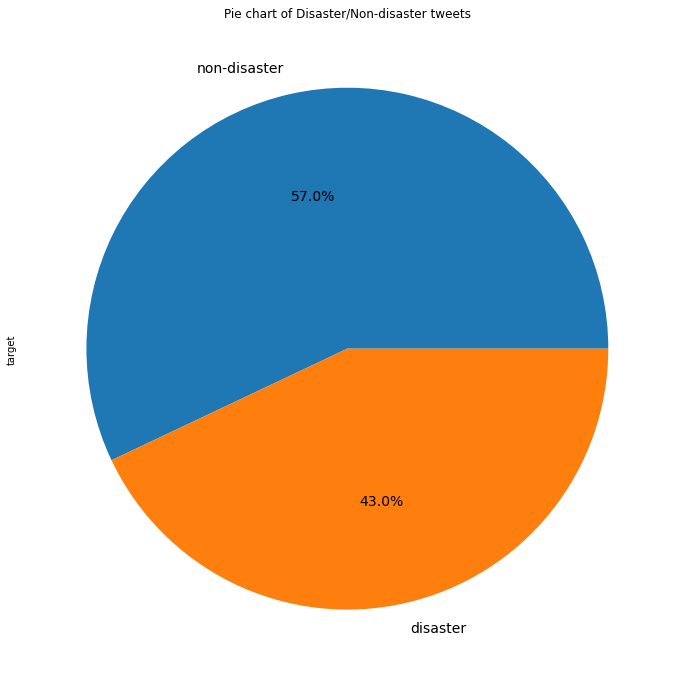

In [20]:
# Some more EDA
# Let us see how many tweets are classified as Disaster Events, and how many are not

df2=train_data.copy(deep=True)
pie1=pd.DataFrame(df2['target'].replace(1,'disaster').replace(0,'non-disaster').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Disaster/Non-disaster tweets',y = 'target', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))


Appears the training output (target) is almost evenly split, 57-43. Which is Good as the model won't need synthetic data to cater to heavy imbalances in training data.

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/sid/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# We need to do some processing, data cleaaning as it is Text Tweets and could have anything in them

from nltk.corpus import stopwords



# Convert all Tweets to Lower case 

train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()


# removing URLS, as they are not real text contents 

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

train_data['text'] = train_data['text'].apply(remove_urls)
test_data['text']  = test_data['text'].apply(remove_urls)


# Remove stop words 

def remove_stopwords(text):
    sw = stopwords.words('english')
    words = text.split(' ')
    filtered = [w for w in words if w not in sw]
    return ' '.join([str(v) for v in filtered])

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text']  = test_data['text'].apply(remove_stopwords)


In [13]:
# Tokenize the Tweets 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 40
n_words = 100000
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(train_data['text'])
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_data['text'])
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(test_data['text'])
testing_padded    = pad_sequences(testing_sequences, padding='post', maxlen=max_length)
print(training_padded.shape)
print(testing_padded.shape)


(7613, 40)
(3263, 40)


In [69]:
# The LSTM Model with relu and Adam 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional


lstm_model_1 = Sequential()
lstm_model_1.add(Embedding(n_words, 50))
lstm_model_1.add(LSTM(50, activation='relu', return_sequences=True))
lstm_model_1.add(LSTM(20, activation='relu', return_sequences=False))
lstm_model_1.add(Dropout(0.2))
lstm_model_1.add(Dense(10, activation='relu'))
lstm_model_1.add(Dense(1, activation='sigmoid'))

lstm_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model_1.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 50)          5000000   
                                                                 
 lstm_24 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_25 (LSTM)              (None, 20)                5680      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 10)                210       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,026,101
Trainable params: 5,026,101
N

In [70]:
# Fit the Model 

epochs = 4
batch_size = 32

y_train = train_data['target']

history = lstm_model_1.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          shuffle=True)


Epoch 1/4
191/191 [==============================] - 13s 53ms/step - loss: 0.6838 - accuracy: 0.5923 - val_loss: 0.6772 - val_accuracy: 0.5424
Epoch 2/4
191/191 [==============================] - 9s 49ms/step - loss: 0.4887 - accuracy: 0.7798 - val_loss: 0.4900 - val_accuracy: 0.7413
Epoch 3/4
191/191 [==============================] - 11s 55ms/step - loss: 0.2648 - accuracy: 0.9090 - val_loss: 0.5784 - val_accuracy: 0.6724
Epoch 4/4
191/191 [==============================] - 11s 57ms/step - loss: 0.1648 - accuracy: 0.9496 - val_loss: 0.7195 - val_accuracy: 0.7380


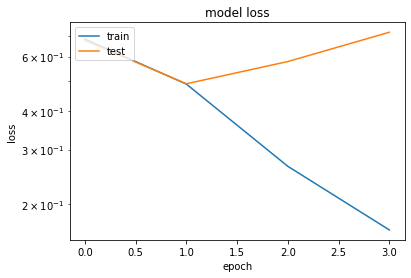

In [71]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


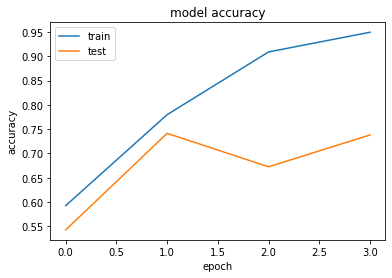

In [72]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [19]:
y_pred = lstm_model_1.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('./sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission_LSTM.csv', index=False)


In [21]:
# Train Test Split 

random_st = 1234

y = train_data['target']

# Split Scaled data into Train and Test sets 
x_train, x_test, y_train, y_test = train_test_split(training_padded, y, test_size=0.2, random_state=random_st)





In [38]:
# LSTM model with Early Stopping and LeakyRelu, let's see how it behaves 

lstm_model_2 = Sequential()
lstm_model_2.add(Embedding(n_words, 50))
lstm_model_2.add(LSTM(50, activation=keras.layers.LeakyReLU(alpha=0.01), return_sequences=True))
lstm_model_2.add(LSTM(20, activation=keras.layers.LeakyReLU(alpha=0.01), return_sequences=False))
#lstm_model_2.add(LSTM(50, activation='tanh', return_sequences=True))
#lstm_model_2.add(LSTM(20, activation='tanh', return_sequences=False))
lstm_model_2.add(Dropout(0.2))
lstm_model_2.add(Dense(10, activation='relu'))
lstm_model_2.add(Dense(1, activation='sigmoid'))


lstm_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model_2.summary()


cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')

history = lstm_model_2.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks = [cb1, cb2], verbose = 1)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          5000000   
                                                                 
 lstm_12 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_13 (LSTM)              (None, 20)                5680      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                210       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,026,101
Trainable params: 5,026,101
No

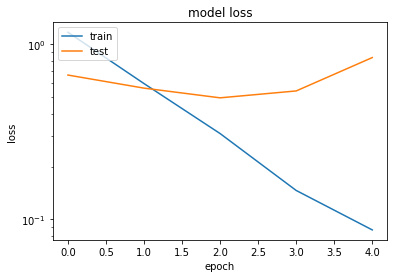

In [39]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

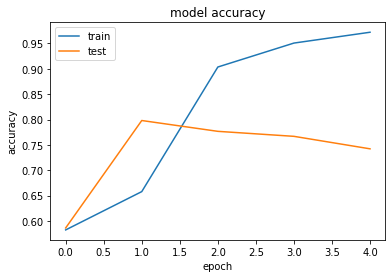

In [40]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Run it over Split test dataset
pred_val = lstm_model_2.predict(x_test)
pred_val[pred_val > 0.5] = 1
pred_val[pred_val <= 0.5] = 0
pred_val



array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

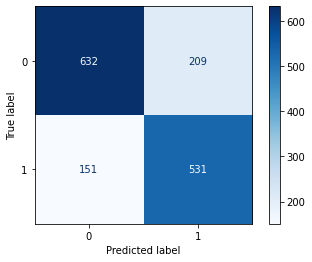

In [44]:
# Let's see the Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_val), display_labels=np.unique(y_test))
disp.plot(cmap='Blues') 
plt.grid(False)


In [45]:
# Kaggle Submission

y_pred = lstm_model_2.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('./sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission_LSTM_2.csv', index=False)


In [46]:
# Another RNN LSTM model_3 


lstm_model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_words, 50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [47]:
lstm_model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [48]:
cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')

history = lstm_model_3.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks = [cb1, cb2], verbose = 1)



Epoch 1/5
153/153 [==============================] - 22s 106ms/step - loss: 0.6841 - accuracy: 0.5720 - val_loss: 0.6720 - val_accuracy: 0.5862 - lr: 1.0000e-04
Epoch 2/5
153/153 [==============================] - 16s 104ms/step - loss: 0.6490 - accuracy: 0.5733 - val_loss: 0.5699 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 3/5
153/153 [==============================] - 15s 98ms/step - loss: 0.4094 - accuracy: 0.8120 - val_loss: 0.4925 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 4/5
153/153 [==============================] - 15s 96ms/step - loss: 0.2530 - accuracy: 0.9019 - val_loss: 0.5486 - val_accuracy: 0.7726 - lr: 1.0000e-04
Epoch 5/5
153/153 [==============================] - 15s 95ms/step - loss: 0.1638 - accuracy: 0.9427 - val_loss: 0.6703 - val_accuracy: 0.7668 - lr: 1.0000e-04


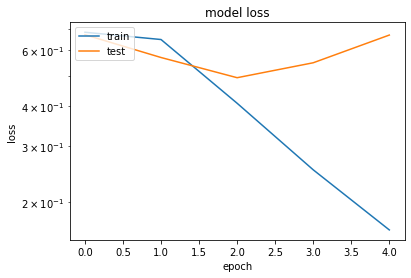

In [49]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

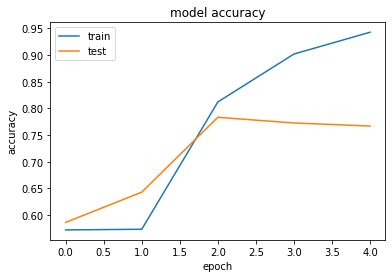

In [50]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Run against hheld back Test Data
pred_val = lstm_model_3.predict(x_test)
pred_val[pred_val > 0.5] = 1
pred_val[pred_val <= 0.5] = 0
pred_val

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

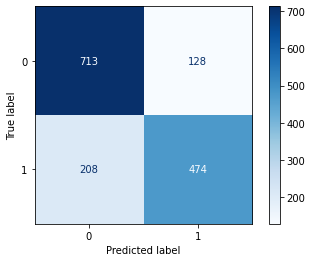

In [52]:
# Let's see the Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_val), display_labels=np.unique(y_test))
disp.plot(cmap='Blues') 
plt.grid(False)

In [53]:
# Kaggle Submission 3 

y_pred = lstm_model_3.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('./sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission_LSTM_3.csv', index=False)

In [54]:
# LSTM model with Early Stopping and Tanh, let's see how it behaves 

lstm_model_4 = Sequential()
lstm_model_4.add(Embedding(n_words, 50))
lstm_model_4.add(LSTM(64, activation='tanh', return_sequences=True))
lstm_model_4.add(LSTM(32, activation='tanh', return_sequences=False))
lstm_model_4.add(Dropout(0.2))
lstm_model_4.add(Dense(10, activation='relu'))
lstm_model_4.add(Dense(1, activation='sigmoid'))


lstm_model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model_4.summary()


cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')

history = lstm_model_4.fit(x_train, y_train, epochs=4, validation_split=0.2, batch_size=32, callbacks = [cb1, cb2], verbose = 1)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          5000000   
                                                                 
 lstm_16 (LSTM)              (None, None, 64)          29440     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                330       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,042,197
Trainable params: 5,042,197
No

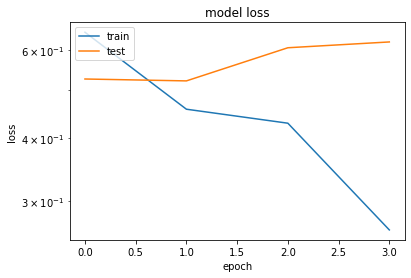

In [55]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

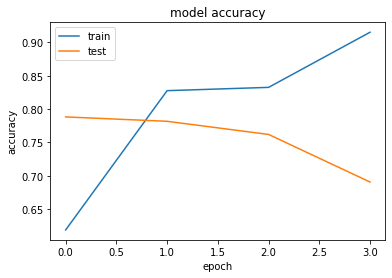

In [56]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Kaggle Submission 4 

y_pred = lstm_model_4.predict(testing_padded)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

sub = pd.read_csv('./sample_submission.csv')
sub['target'] = y_pred.round(0).astype('int')
sub.to_csv('submission_LSTM_4.csv', index=False)

# RNN LSTM Models Summary

  These LSTM RNN models I found very powerful in performing NLP tasks. The problem was to predict from the small tweets if there is a hazardous weather condition. The 3 LSTM models performed well and gave a Kaggle score of around 0.75. From running the RNNs I found that the models are very prone to overfitting. So low numbers of Epochs did the trick for me. I ran some of these models with 20, 50 epoches and the overfitting was very very significant, so I used 4-5 Epochs for training. 
  I tried with different activation functions, like relu, leakyrelu, tanh and compared the results, and only picked the models that gave better results. Here we have 4 Kaggle submissions, and in the screenshot I have picked the best 3 scores.
  I think this NLP task is introductory level, we have a small tweet of a few words. The models are pretty simple and gave reasonably good results. For large scale NLP like reading through Books, length articles, legal forms, financial reports we would need much complex NLP models using various nltk features and also much larger CPU/GPU power.
  
  
  
  

